In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.datasets import load_breast_cancer
from torchvision import datasets, transforms

In [4]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df['class'] = cancer['target']
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [10]:
data = torch.from_numpy(df.values).float()
X = data[:, :-1]
y = data[:, -1:]
X.shape, y.shape

(torch.Size([569, 30]), torch.Size([569, 1]))

In [11]:
ratios = [0.6, 0.2, 0.2]
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[341, 113, 115]

In [12]:
indices = torch.randperm(data.shape[0])
X = list(torch.index_select(X, dim=0, index=indices).split(cnts, dim=0))
y = list(torch.index_select(y, dim=0, index=indices).split(cnts, dim=0))

for X_i, y_i in zip(X, y):
    print(X_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [13]:
scaler = StandardScaler()
scaler.fit(X[0].numpy())
X[0] = torch.from_numpy(scaler.transform(X[0].numpy())).float()
X[1] = torch.from_numpy(scaler.transform(X[1].numpy())).float()
X[2] = torch.from_numpy(scaler.transform(X[2].numpy())).float()

In [14]:
model = nn.Sequential(
    nn.Linear(X[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid()
)
optimizer = optim.Adam(model.parameters())

In [26]:
n_epochs = 5000
batch_size = 16
print_interval = 100

In [20]:
lowest_loss = np.inf
lowest_epoch = np.inf
best_model = None
early_stop = 200

In [27]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(X[0].shape[0])
    X_ = torch.index_select(X[0], dim=0, index=indices).split(batch_size, dim=0)
    y_ = torch.index_select(y[0], dim=0, index=indices).split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
    
    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0
        
        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.6f}, valid loss={valid_loss:.6f}, lowest loss={lowest_loss:.6f}')

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.6f}')

model.load_state_dict(best_model)

Epoch 100: train loss=0.000013, valid loss=1.665496, lowest loss=0.140125
Epoch 200: train loss=0.000002, valid loss=1.684214, lowest loss=0.140125
There is no improvement during last 200 epochs.
The best validation loss from epoch 1: 0.140125


<All keys matched successfully>

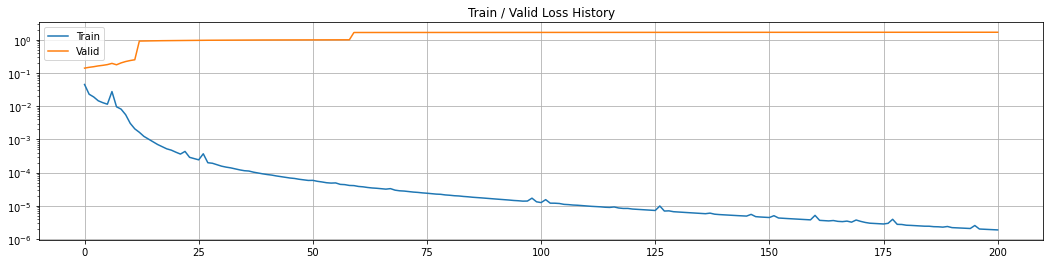

In [28]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [29]:
test_loss = 0
y_hat = []

with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.6f}')
print(f'Valid loss: {sorted_history[0][1]:.6f}')
print(f'Test loss: {test_loss:.6f}')

Train loss: 0.045093
Valid loss: 0.140125
Test loss: 0.137934


In [30]:
correct_cnt = (y[2] == (y_hat > 0.5)).sum()
total_cnt = float(y[2].size(0))

print(f'Test Accuracy: {correct_cnt / total_cnt:.4f}')

Test Accuracy: 0.9565


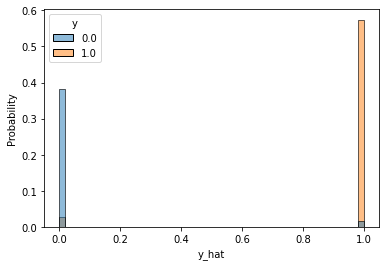

In [33]:
df = pd.DataFrame(torch.concat([(y_hat > 0.5).float(), y[2]], dim=1).detach().numpy(), columns=['y', 'y_hat'])
sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [34]:
roc_auc_score(df.values[:, 0], df.values[:, 1])

0.9565217391304348